*First compiled on May 5th, 2017.*

# Clustering 3k PBMCs following a Seurat Tutorial

Scanpy allows to reproduce most of Seurat's ([Satija *et al.*, 2015](https://doi.org/10.1038/nbt.3192)) standard clustering tutorial as described on http://satijalab.org/seurat/pbmc3k_tutorial.html (July 26, 2017). We gratefully acknowledge  the Seurat authors for publishing the tutorial!

The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)).

In [2]:
import numpy as np
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.logging = 5
results_file= './write/pmbc3k.h5ad'

/cluster/work/bewi/members/tuncel/anaconda3/envs/r-3.4.1-env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
path = '/cluster/home/mtuncel/sc-pipe/data/pbmc3k/filtered_gene_bc_matrices/hg19/'
adata = sc.read(path + 'matrix.mtx', cache=True).transpose()
adata.var_names = np.genfromtxt(path + 'genes.tsv', dtype=str)[:, 1]
adata.obs_names = np.genfromtxt(path + 'barcodes.tsv', dtype=str)

... writing an h5 cache file to speedup reading next time


## Preprocessing

Basic filtering.

In [3]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

Plot some information about mitochondrial genes, important for quality control

In [4]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the ".A1" is only necessary, as X is sparse - it transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1

A violin plot of the computed quality measures.

/cluster/work/bewi/members/tuncel/anaconda3/envs/r-3.4.1-env/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/cluster/work/bewi/members/tuncel/anaconda3/envs/r-3.4.1-env/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


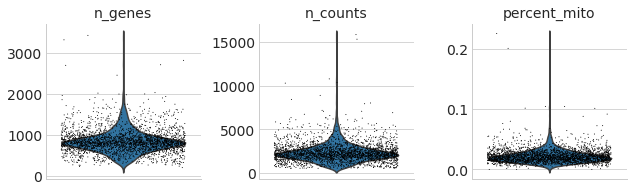

In [5]:
axs = sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                   jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

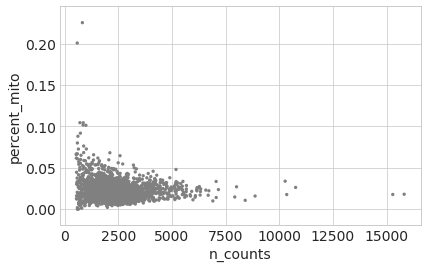

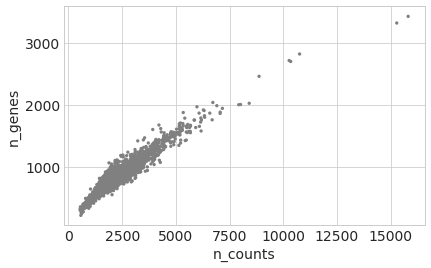

In [6]:
ax = sc.pl.scatter(adata, x='n_counts', y='percent_mito')
ax = sc.pl.scatter(adata, x='n_counts', y='n_genes')

Actually do the filtering.

In [7]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the data stored in `adata_raw`.

In [8]:
adata_raw = sc.pp.log1p(adata, copy=True)
adata.raw = adata_raw

Per-cell normalize the data matrix $\mathbf{X}$, identify highly-variable genes and compute logarithm.

normalizing by total count per cell
    finished (0:00:00.043): normalized adata.X and added
    'n_counts', counts per cell before normalization (adata.obs)
filter highly variable genes by dispersion and mean (0:00:00.113)
--> set `n_top_genes` to simply select top-scoring genes instead


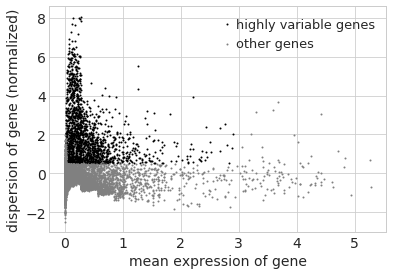

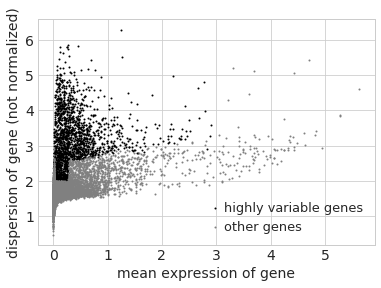

In [9]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

Actually do the filtering.

In [10]:
adata = adata[:, filter_result.gene_subset]

Logarithmize the data.

In [11]:
sc.pp.log1p(adata)

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [12]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

/cluster/work/bewi/members/tuncel/anaconda3/envs/r-3.4.1-env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


HBox(children=(IntProgress(value=0, max=4), HTML(value='')))


--> after `sc.pp.regress_out`, consider rescaling the adata using `sc.pp.scale`


In [13]:
sc.pp.scale(adata, max_value=10)

Save the result.

In [14]:
adata.write(results_file)

## PCA

Compute PCA and make a scatter plot.

In [15]:
sc.tl.pca(adata)

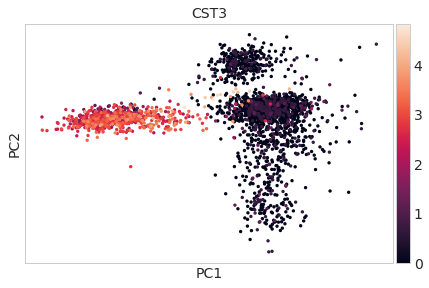

In [16]:
adata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat R
ax = sc.pl.pca_scatter(adata, color='CST3', right_margin=0.2)

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine. Seurat provides many more functions, here.

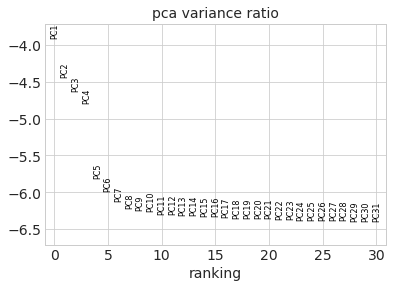

In [17]:
sc.pl.pca_variance_ratio(adata, log=True)

In [18]:
adata.shape

(2638, 1838)

## tSNE

In [18]:
adata = sc.read(results_file)

In [19]:
sc.tl.tsne(adata, n_pcs=10, random_state=2)
adata.write(results_file)

computing tSNE
    compute 'X_pca' with n_pcs = 10
--> avoid this by setting n_pcs = 0
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:27.512) --> added
    'X_tsne', tSNE coordinates (adata.obs)


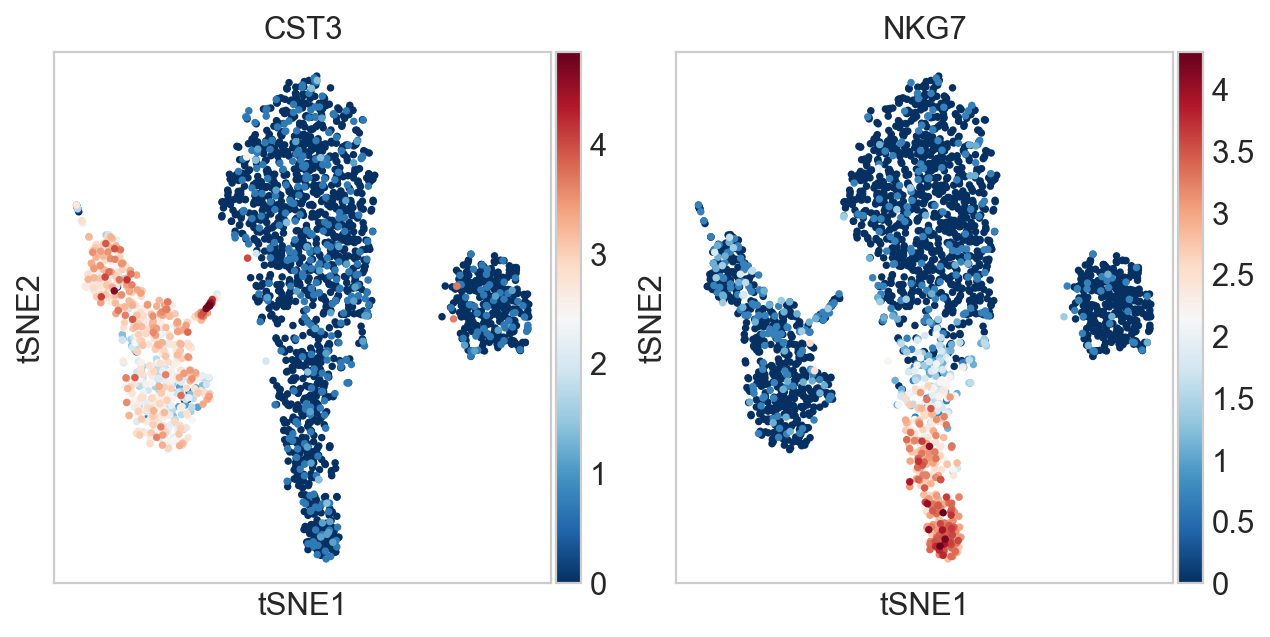

In [20]:
ax = sc.pl.tsne(adata, color=['CST3', 'NKG7'], color_map='RdBu_r')

As we set the `.raw` attribute of AnnData (a "frozen" state of the object at a point in the pipeline where we deemed the data "raw"), the previous plots showed the raw gene expression.

By setting `use_raw` to `False`, we can also plot the scaled and corrected expression.

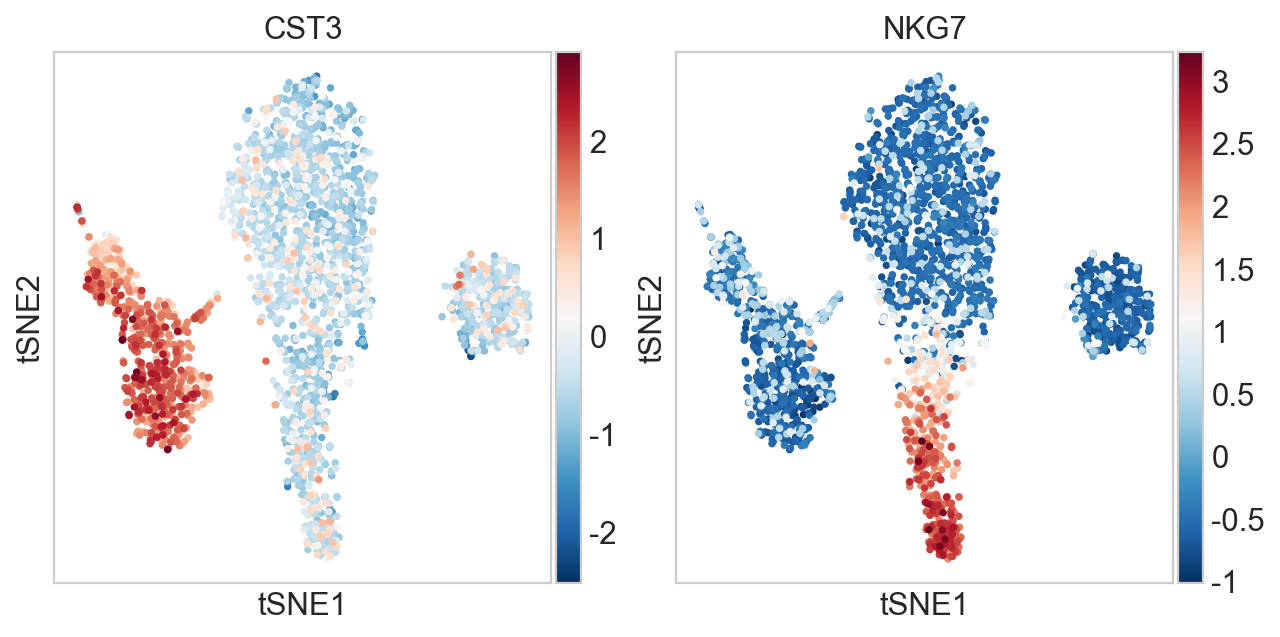

In [21]:
ax = sc.pl.tsne(adata, color=['CST3', 'NKG7'], color_map='RdBu_r', use_raw=False)

## Clustering

As Seurat and many others, we use the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine *et al.* (2015)](https://doi.org/10.1016/j.cell.2015.05.04).

In [19]:
adata = sc.read(results_file)

In [20]:
adata.shape

(2638, 1838)

In [ ]:
sc.tl.louvain(adata, n_neighbors=10, resolution=1.3, recompute_graph=True)

running Louvain clustering
    compute 'X_pca' with n_pcs = 50 for building graph


Plot the data with tSNE. Coloring according to clustering. Clusters agree quite well with the result of Seurat.

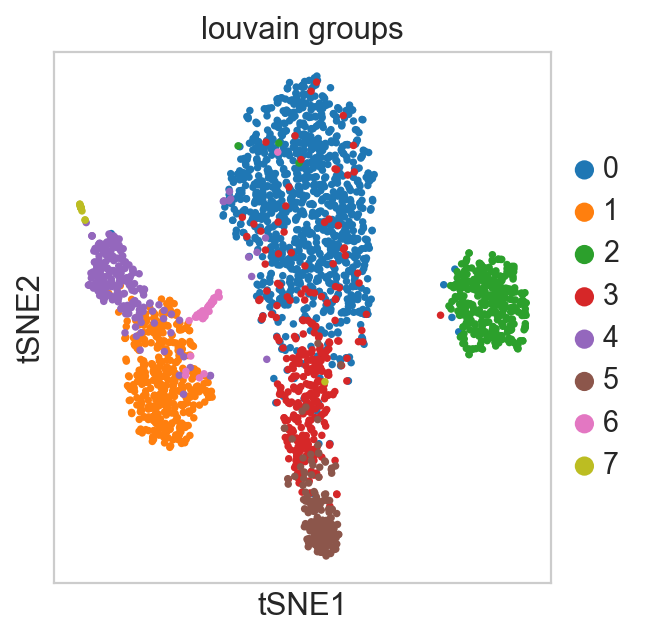

In [24]:
ax = sc.pl.tsne(adata, color='louvain_groups')

Save this, in case we need it later.

In [25]:
adata.write(results_file)

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. Here, we simply rank genes by z-score, this agrees quite well with the more advanced tests of Seurat.

For this, by default, the `.raw` attribute of AnnData is used - if it's present.

rank differentially expressed genes
    consider 'louvain_groups': ['0' '1' '2' '3' '4' '5' '6' '7'] with sample numbers [1110  417  340  328  219  166   42   16]
    finished (0:00:00.853) --> added
    'rank_genes_groups_gene_names', np.recarray to be indexed by group ids (adata.uns)
    'rank_genes_groups_gene_scores', np.recarray to be indexed by group ids (adata.uns)
... you are using a very low resolution for saving figures, adjusting to dpi=300
saving figure to file ./figures/rank_genes_groups_louvain_groups.pdf


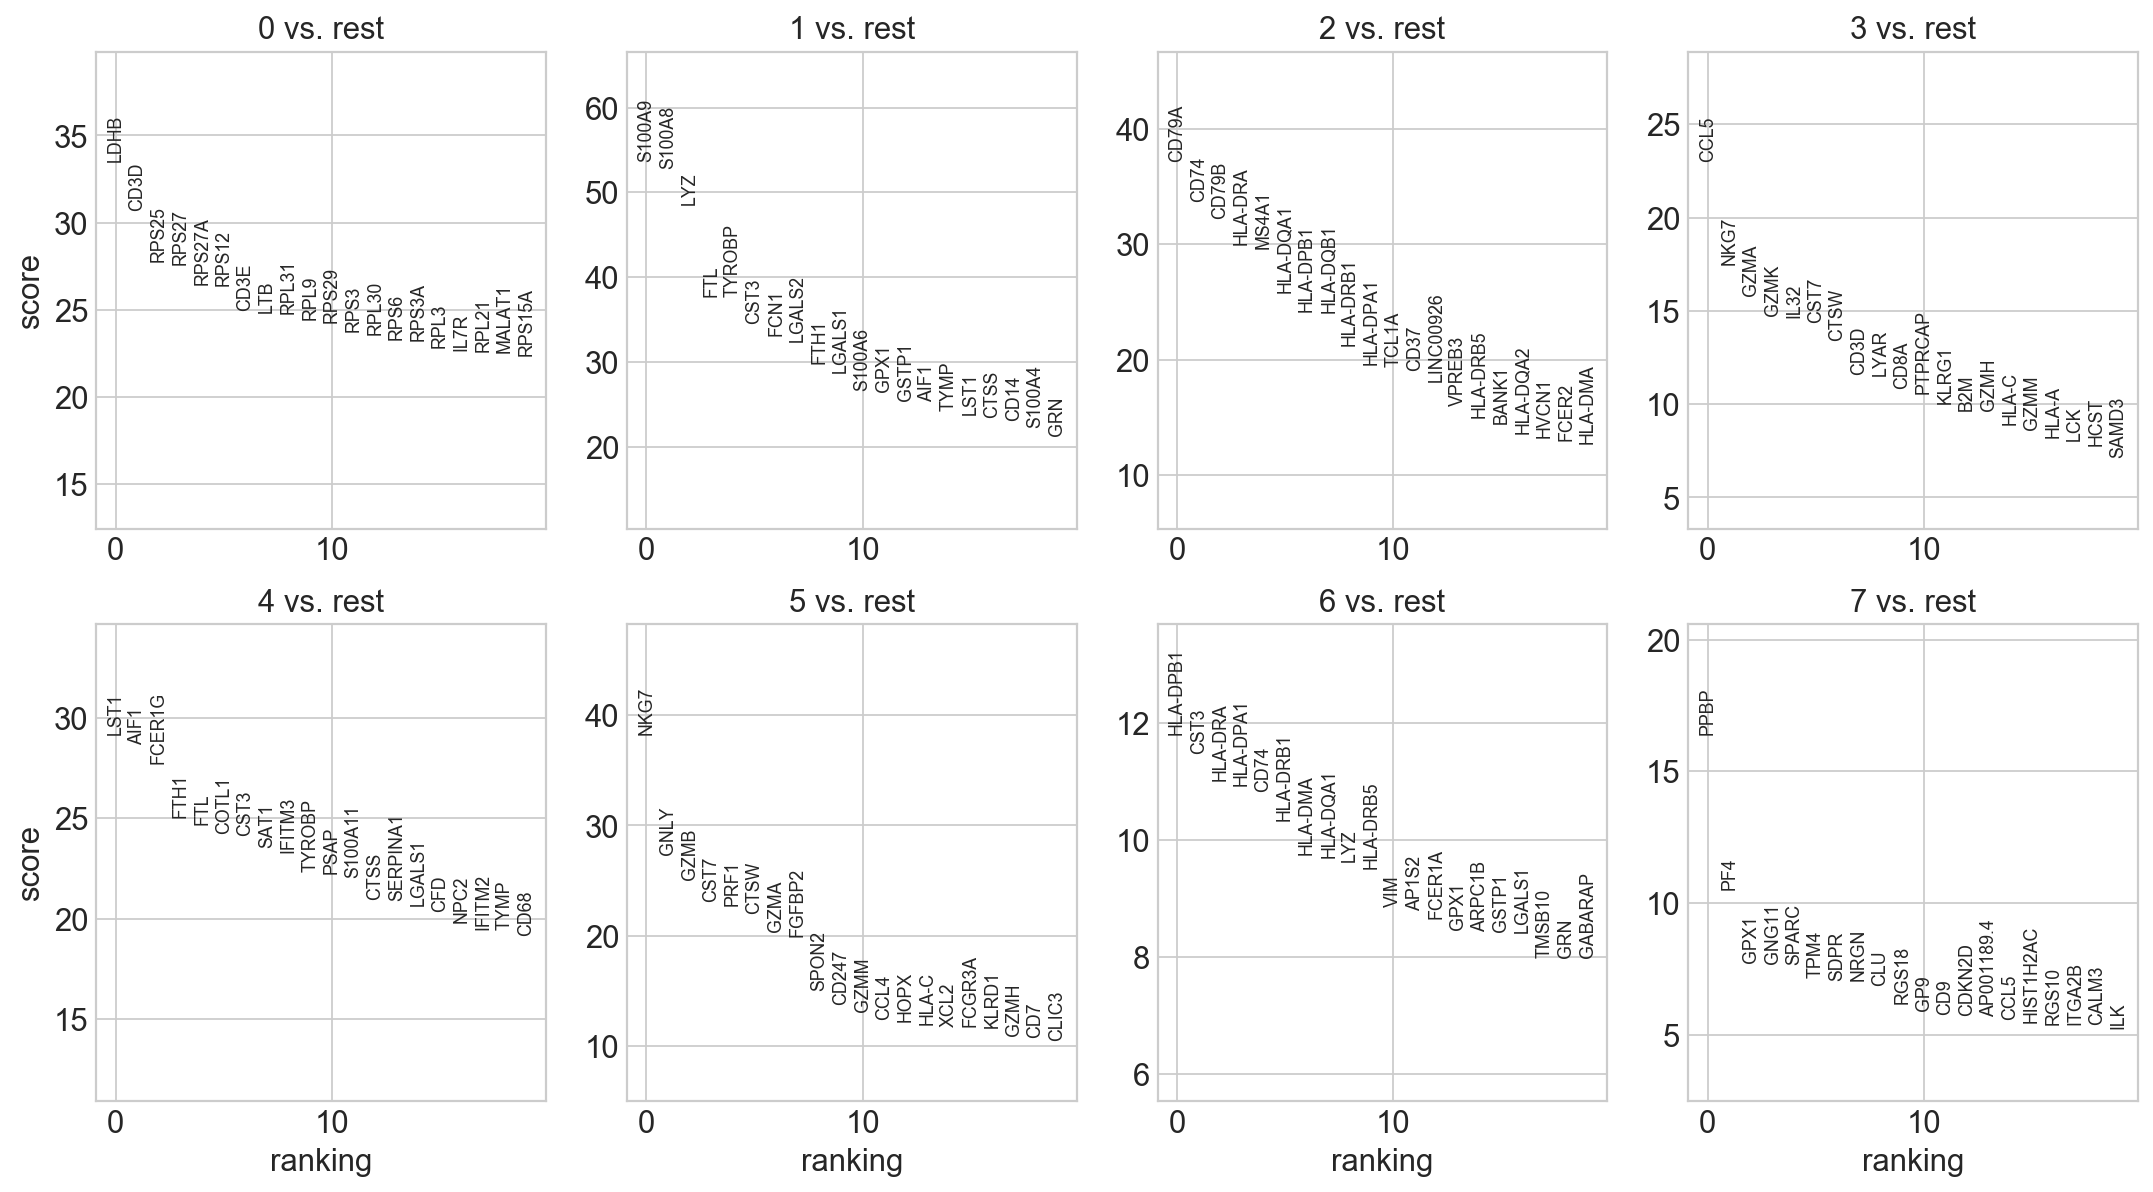

In [26]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain_groups')
sc.pl.rank_genes_groups(adata, n_genes=20, save='.pdf')
adata.write(results_file)

Show the 20 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [27]:
import pandas as pd
pd.DataFrame(adata.uns['rank_genes_groups_gene_names']).loc[:20]

,0,1,2,3,4,5,6,7
0,LDHB,S100A9,CD79A,CCL5,LST1,NKG7,HLA-DPB1,PPBP
1,CD3D,S100A8,CD74,NKG7,AIF1,GNLY,CST3,PF4
2,RPS25,LYZ,CD79B,GZMA,FCER1G,GZMB,HLA-DRA,GPX1
3,RPS27,FTL,HLA-DRA,GZMK,FTH1,CST7,HLA-DPA1,GNG11
4,RPS27A,TYROBP,MS4A1,IL32,FTL,PRF1,CD74,SPARC
5,RPS12,CST3,HLA-DQA1,CST7,COTL1,CTSW,HLA-DRB1,TPM4
6,CD3E,FCN1,HLA-DPB1,CTSW,CST3,GZMA,HLA-DMA,SDPR
7,LTB,LGALS2,HLA-DQB1,CD3D,SAT1,FGFBP2,HLA-DQA1,NRGN
8,RPL31,FTH1,HLA-DRB1,LYAR,IFITM3,SPON2,LYZ,CLU
9,RPL9,LGALS1,HLA-DPA1,CD8A,TYROBP,CD247,HLA-DRB5,RGS18


Even though the ranking by z-scores is a very simple procedure, the resulting genes agree very well with the marker genes fround by Seurat. With the exception of the marker genes of group 4, all marker genes mentioned in the [Seurat Tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html) can be found the rankings, and one can hence identify the cell types.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | 0
1 | CD14, LYZ | 1
2 | MS4A1 |	B cells
3 |	CD8A |	CD8 T cells
4 |	FCGR3A, MS4A7 |	FCGR3A+ Monocytes
5 |	GNLY, NKG7 | 	NK cells
6 |	FCER1A, CST3 |	Dendritic Cells
7 |	PPBP |	Megakaryocytes

Compare to a single cluster. 

rank differentially expressed genes
    consider 'louvain_groups': ['0' '1'] with sample numbers [1110  417]
    finished (0:00:00.074) --> added
    'rank_genes_groups_gene_names', np.recarray to be indexed by group ids (adata.uns)
    'rank_genes_groups_gene_scores', np.recarray to be indexed by group ids (adata.uns)


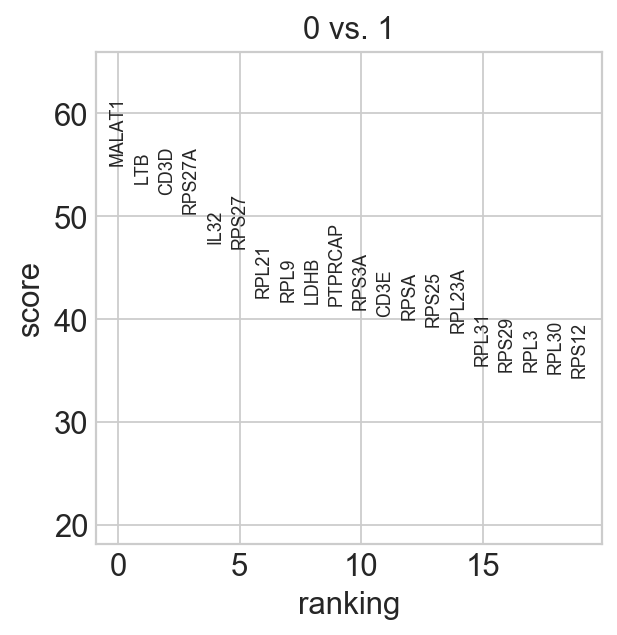

In [28]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain_groups', groups=['0'], reference='1')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

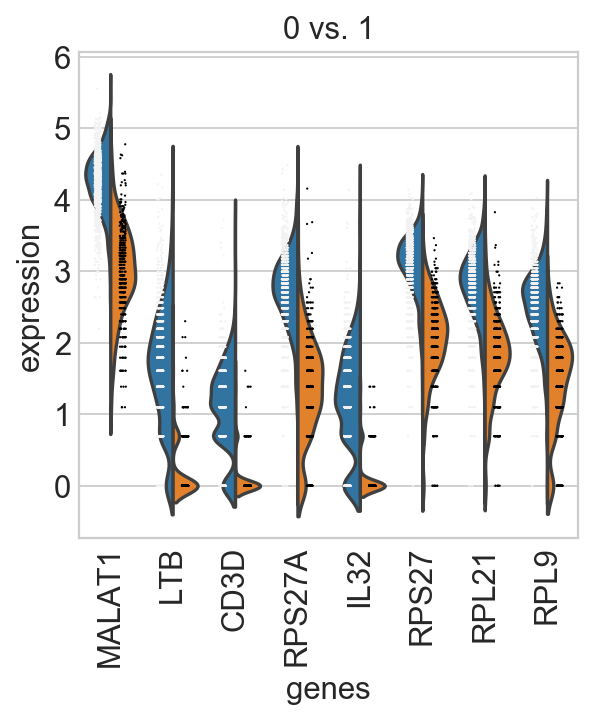

In [29]:
ax = sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

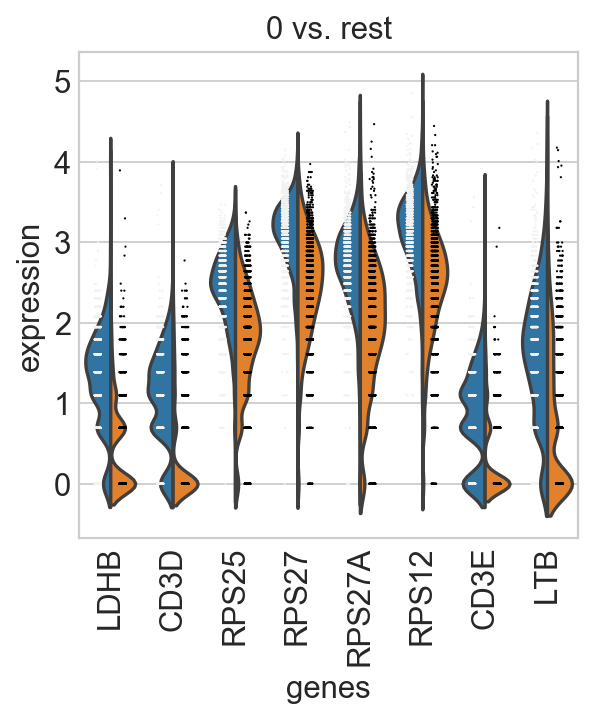

In [30]:
adata = sc.read(results_file)
ax = sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

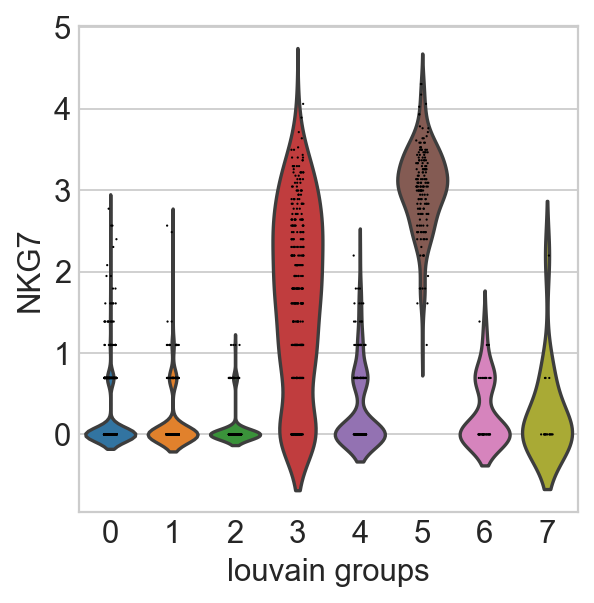

In [31]:
ax = sc.pl.violin(adata, 'NKG7', group_by='louvain_groups')

Actually mark the cell types.

In [32]:
adata = sc.read(results_file)
adata.obs['louvain_groups'].cat.categories = [
    "CD4 T cells", "CD14+ Monocytes",
    "B cells", "CD8 T cells", 
    "FCGR3A+ Monocytes", "NK cells",
    "Dendritic cells", "Megakaryocytes"]
adata.write(results_file)

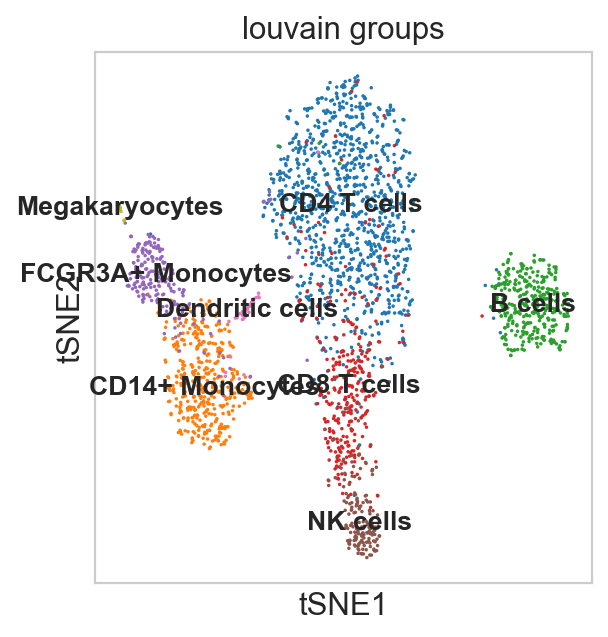

In [33]:
adata = sc.read(results_file)
axs = sc.pl.tsne(adata, size=10,
                 legend_fontsize=12, legend_fontweight='bold',
                 color='louvain_groups',
                 legend_loc='on data')

## Saving or exporting the results

Write the results using compression to save diskspace.

In [34]:
adata.write(results_file)

If you want to export to "csv", you will usually use pandas.

In [35]:
# Export single fields of the annotation of observations
adata.obs[['n_counts', 'louvain_groups']].to_csv(
    './write/pbmc3k_corrected_louvain_groups.csv')

In [36]:
# Export single columns of the multidimensional annotation
adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
    './write/pbmc3k_corrected_X_pca.csv')

In [37]:
# Or export everything except the data using `.write_csvs`.
adata.write_csvs(results_file[:-5])